In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading option chain data
df = pd.read_csv('nifty_option_chain.csv')
df.head()

,strike,expiry,CE_lastPrice,CE_bid,CE_ask,PE_lastPrice,PE_bid,PE_ask
0,16000,30-Dec-25,10090.00,10057.20,10584.65,1.50,1.50,1.75
1,17000,30-Dec-25,9305.00,9305.10,9390.40,1.70,1.55,1.70
2,18000,30-Dec-25,8375.25,8271.90,8396.00,2.15,1.90,2.15
3,19000,30-Dec-25,7140.00,7191.70,7430.05,11.00,3.00,8.35
4,20000,30-Dec-25,6360.00,6348.25,6388.10,3.75,3.75,3.80


In [4]:
# -----------------------------
# 2) Valuation date, expiry, time-to-expiry for put-call parity
# -----------------------------
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from math import erf, sqrt
import pickle
np.random.seed(123)

# FIX: Convert to datetime
vix_df['Date'] = pd.to_datetime(vix_df['Date'])

valuation_date = vix_df['Date'].max()         # latest VIX date
expiry = pd.to_datetime(df['expiry'].iloc[0], dayfirst=False)

T_days_to_expiry = (expiry - valuation_date).days
T_to_expiry = T_days_to_expiry / 365.0

if T_to_expiry <= 0:
    raise ValueError("Expiry is not after valuation date in the provided data.")


In [5]:
# -----------------------------
# 3) Estimate spot using put-call parity: C - P + K*e^{-rT} = S
# -----------------------------
r = 0.02   # assume risk-free rate (change if you want)
df['stockprice'] = df['CE_lastPrice'] - df['PE_lastPrice'] + df['strike'] * np.exp(-r * T_to_expiry)
S0 = df['stockprice'].median()   # robust central estimate
K_choice = int(df.loc[(df['strike'] - S0).abs().idxmin(), 'strike'])

In [6]:
df

,strike,expiry,CE_lastPrice,CE_bid,CE_ask,PE_lastPrice,PE_bid,PE_ask,stockprice
0,16000,30-Dec-25,10090.00,10057.20,10584.65,1.50,1.50,1.75,26060.469787
1,17000,30-Dec-25,9305.00,9305.10,9390.40,1.70,1.55,1.70,26273.517899
2,18000,30-Dec-25,8375.25,8271.90,8396.00,2.15,1.90,2.15,26341.566010
3,19000,30-Dec-25,7140.00,7191.70,7430.05,11.00,3.00,8.35,26095.714122
4,20000,30-Dec-25,6360.00,6348.25,6388.10,3.75,3.75,3.80,26321.212234
...,...,...,...,...,...,...,...,...,...
109,27950,30-Dec-25,0.00,22.90,26.80,1556.85,1415.30,1835.80,26344.184722
110,28000,30-Dec-25,9.00,8.55,9.00,1596.00,1590.00,1596.00,26363.947127
111,29000,30-Dec-25,3.80,3.45,3.85,2596.05,2558.55,2592.60,26356.945239
112,30000,30-Dec-25,2.50,2.10,2.50,3577.00,3564.30,3584.35,26372.943351


In [7]:
# -----------------------------
# 4) Initial variance from latest VIX
# -----------------------------
latest_vix = vix_df['VIX'].iloc[0]
v0 = (latest_vix / 100.0)**2

In [8]:
latest_vix

12.14999962

In [9]:
v0

0.014762249076600011

In [10]:
# -----------------------------
# 5) Heston parameters (adjustable)
# -----------------------------
kappa = 3.0       # mean-reversion speed
theta = 0.04        # long-run variance (set to v0 here; change if desired)
sigma = 0.5       # vol-of-vol
rho = -0.7      # correlation between asset and variance Brownian motions
r = 0.02

In [11]:
# -----------------------------
# 6) Simulation settings (adjust M for accuracy)
# -----------------------------
T_sim = 1.0       # simulate 1 year returns as requested
N = 252           # steps per year (trading days)
dt = T_sim / N
M = 2000          # Monte Carlo paths (increase for accuracy)
sqrt_dt = np.sqrt(dt)

In [12]:
# -----------------------------
# 7) Simulate Heston: Euler-Maruyama with full truncation
# -----------------------------
S_h = np.zeros((M, N+1))
var_h = np.zeros((M, N+1))

S_h[:,0] = S0
var_h[:,0] = v0

for t in range(1, N+1):
    z1 = np.random.normal(size=M)
    z2 = np.random.normal(size=M)
    # correlated increments
    w1 = z1
    w2 = rho * z1 + np.sqrt(1 - rho**2) * z2
    v_prev = var_h[:, t-1]
    # variance update (full truncation: sqrt uses max(v_prev,0))
    dv = kappa * (theta - np.maximum(v_prev, 0)) * dt + sigma * np.sqrt(np.maximum(v_prev, 0)) * sqrt_dt * w2
    v_new = v_prev + dv
    v_new = np.maximum(v_new, 0.0)   # floor at zero
    var_h[:, t] = v_new
    # stock update using v_prev (or v_new depending on scheme) - here we use v_prev for diffusion term
    S_prev = S_h[:, t-1]
    S_h[:, t] = S_prev * np.exp((r - 0.5 * np.maximum(v_prev, 0)) * dt + np.sqrt(np.maximum(v_prev, 0)) * sqrt_dt * w1)

In [13]:
# -----------------------------
# 8) Simulate Black-Scholes (GBM) with constant vol = sqrt(v0)
# -----------------------------
sigma_bs = np.sqrt(v0)
S_bs = np.zeros((M, N+1))
S_bs[:,0] = S0
for t in range(1, N+1):
    z = np.random.normal(size=M)
    S_bs[:, t] = S_bs[:, t-1] * np.exp((r - 0.5 * sigma_bs**2) * dt + sigma_bs * sqrt_dt * z)

In [14]:
# -----------------------------
# 9) Terminal prices, returns, and MC call prices
# -----------------------------
S_T_h = S_h[:, -1]
S_T_bs = S_bs[:, -1]
returns_h = S_T_h / S0 - 1.0
returns_bs = S_T_bs / S0 - 1.0

In [15]:
S_T_h

array([25747.63581208, 28337.65722406, 28106.84297218, ...,
       35355.82049414, 22337.32791027, 31889.82351988])

In [16]:
S_T_bs

array([25839.12343798, 24067.11047471, 25375.56985827, ...,
       26616.1612106 , 22081.17296099, 23888.80798567])

In [17]:
returns_h

array([-0.02252329,  0.07580362,  0.06704105, ...,  0.34223939,
       -0.15199136,  0.21065716])

In [18]:
returns_bs

array([-0.01905008, -0.08632233, -0.03664831, ...,  0.01044918,
       -0.16171596, -0.09309136])

In [19]:
# Monte Carlo discounted call price (strike K_choice) under Heston and BS
payoff_h = np.maximum(S_T_h - K_choice, 0.0)
price_h_mc = np.exp(-r * T_sim) * payoff_h.mean()

payoff_bs = np.maximum(S_T_bs - K_choice, 0.0)
price_bs_mc = np.exp(-r * T_sim) * payoff_bs.mean()

In [20]:
payoff_h

array([   0.        , 1987.65722406, 1756.84297218, ..., 9005.82049414,
          0.        , 5539.82351988])

In [21]:
price_h_mc

2017.9511167099472

In [22]:
payoff_bs

array([  0.       ,   0.       ,   0.       , ..., 266.1612106,
         0.       ,   0.       ])

In [23]:
price_bs_mc

1508.9286085135845

In [24]:
# Black-Scholes analytic price (for comparison)
def norm_cdf(x):
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def bs_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm_cdf(d1) - K * np.exp(-r * T) * norm_cdf(d2)

price_bs_analytic = bs_call_price(S0, K_choice, T_sim, r, sigma_bs)


In [25]:
price_bs_analytic

1536.4007228700702

In [26]:
# 10) Summarize and display results
# -----------------------------
summary = {
    'S0_estimate': S0,
    'chosen_strike_K': K_choice,
    'valuation_date': valuation_date.date().isoformat(),
    'expiry': expiry.date().isoformat(),
    'T_years_until_expiry': T_to_expiry,
    'latest_VIX': latest_vix,
    'v0': v0,
    'heston_params': {'kappa':kappa, 'theta':theta, 'sigma':sigma, 'rho':rho, 'r':r},
    'MC_paths': M,
    'steps_per_year': N,
    'heston_call_price_MC': price_h_mc,
    'bs_call_price_analytic': price_bs_analytic,
    'bs_call_price_MC': price_bs_mc,
    'returns_heston_mean': returns_h.mean(),
    'returns_heston_std': returns_h.std(),
    'returns_bs_mean': returns_bs.mean(),
    'returns_bs_std': returns_bs.std()
}

results_df = pd.DataFrame(list(summary.items()), columns=['metric','value'])
print("=== Summary ===")
print(results_df.to_string(index=False))


=== Summary ===
                metric                                                               value
           S0_estimate                                                        26340.920079
       chosen_strike_K                                                               26350
        valuation_date                                                          2025-11-28
                expiry                                                          2025-12-30
  T_years_until_expiry                                                            0.087671
            latest_VIX                                                               12.15
                    v0                                                            0.014762
         heston_params {'kappa': 3.0, 'theta': 0.04, 'sigma': 0.5, 'rho': -0.7, 'r': 0.02}
              MC_paths                                                                2000
        steps_per_year                                                    

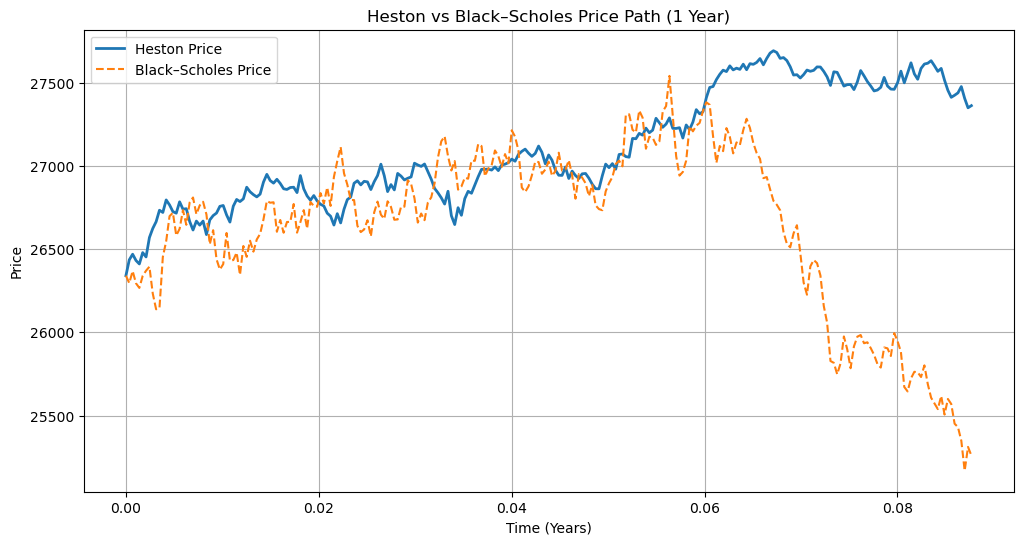

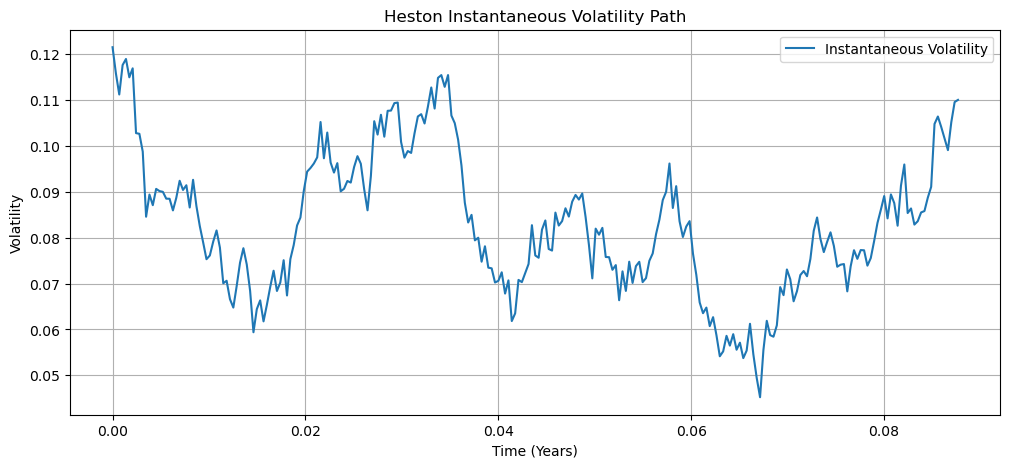

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Parameters
# -----------------------------
S0 = 26340.92
r = 0.02
T = 0.087671
N = 252
dt = T / N
sqrt_dt = np.sqrt(dt)

# Heston parameters
kappa = 3.0
theta = 0.04      # long-run variance
sigma = 0.5        # vol of vol
rho = -0.7         # correlation
v0 = 0.014762          # initial variance

# Number of simulations (we only plot 1 path)
M = 1

# -----------------------------
# 2) Storage
# -----------------------------
S_h = np.zeros((M, N+1))
var_h = np.zeros((M, N+1))

S_h[:, 0] = S0
var_h[:, 0] = v0

# -----------------------------
# 3) Simulate Heston: Euler-Maruyama (full truncation)
# -----------------------------
for t in range(1, N+1):
    z1 = np.random.normal(size=M)
    z2 = np.random.normal(size=M)

    # correlated Wiener increments
    w1 = z1
    w2 = rho * z1 + np.sqrt(1 - rho**2) * z2

    v_prev = var_h[:, t-1]
    S_prev = S_h[:, t-1]

    # variance update
    dv = (
        kappa * (theta - np.maximum(v_prev, 0)) * dt +
        sigma * np.sqrt(np.maximum(v_prev, 0)) * sqrt_dt * w2
    )
    v_new = np.maximum(v_prev + dv, 0.0)
    var_h[:, t] = v_new

    # stock update
    S_h[:, t] = S_prev * np.exp(
        (r - 0.5 * np.maximum(v_prev, 0)) * dt +
        np.sqrt(np.maximum(v_prev, 0)) * sqrt_dt * w1
    )

# -----------------------------
# 4) Black–Scholes path
# -----------------------------
bs_vol = np.sqrt(theta)     # BS volatility = sqrt(long-run variance)
S_bs = np.zeros(N+1)
S_bs[0] = S0

for t in range(1, N+1):
    z = np.random.normal()
    S_bs[t] = S_bs[t-1] * np.exp(
        (r - 0.5 * bs_vol**2) * dt +
        bs_vol * np.sqrt(dt) * z
    )

# -----------------------------
# 5) Plot results
# -----------------------------
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(12,6))
plt.plot(time_grid, S_h[0], label="Heston Price", linewidth=2)
plt.plot(time_grid, S_bs, label="Black–Scholes Price", linestyle='--')
plt.title("Heston vs Black–Scholes Price Path (1 Year)")
plt.xlabel("Time (Years)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 6) Plot instantaneous volatility (sqrt(v_t))
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(time_grid, np.sqrt(var_h[0]), label="Instantaneous Volatility")
plt.title("Heston Instantaneous Volatility Path")
plt.xlabel("Time (Years)")
plt.ylabel("Volatility")
plt.grid(True)
plt.legend()
plt.show()



In [63]:
## Method 1b
def simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N):
    dt = T / N
    S = np.zeros(N+1)
    v = np.zeros(N+1)

    S[0] = S0
    v[0] = v0

    for t in range(1, N+1):
        z1 = np.random.normal()
        z2 = np.random.normal()

        # correlated Brownian motion
        w1 = z1
        w2 = rho*z1 + np.sqrt(1-rho**2)*z2

        # Volatility process
        v[t] = np.abs(
            v[t-1] + kappa*(theta - v[t-1])*dt + sigma*np.sqrt(v[t-1]*dt)*w2
        )

        # Price process
        S[t] = S[t-1] * np.exp(
            (r - 0.5*v[t-1])*dt + np.sqrt(v[t-1]*dt)*w1
        )

    return S, v

In [65]:
def simulate_bs(S0, r, vol, T, N):
    dt = T / N
    S = np.zeros(N+1)
    S[0] = S0

    for t in range(1, N+1):
        z = np.random.normal()
        S[t] = S[t-1] * np.exp(
            (r - 0.5*vol**2)*dt + vol*np.sqrt(dt)*z
        )

    # "Volatility path" = constant volatility (flat line)
    v = np.ones(N+1) * vol**2

    return S, v

In [77]:
S0 = 26340.92
T = 0.087671
N = 252
r = 0.02

# Heston parameters
kappa = 3.0
theta = 0.04
sigma = 0.5
v0 = 0.014762           # start with 20% variance → 44% vol
rho = -0.7

In [79]:
bs_vol = np.sqrt(theta)

In [81]:
S_h, v_h = simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N)
S_bs, v_bs = simulate_bs(S0, r, bs_vol, T, N)

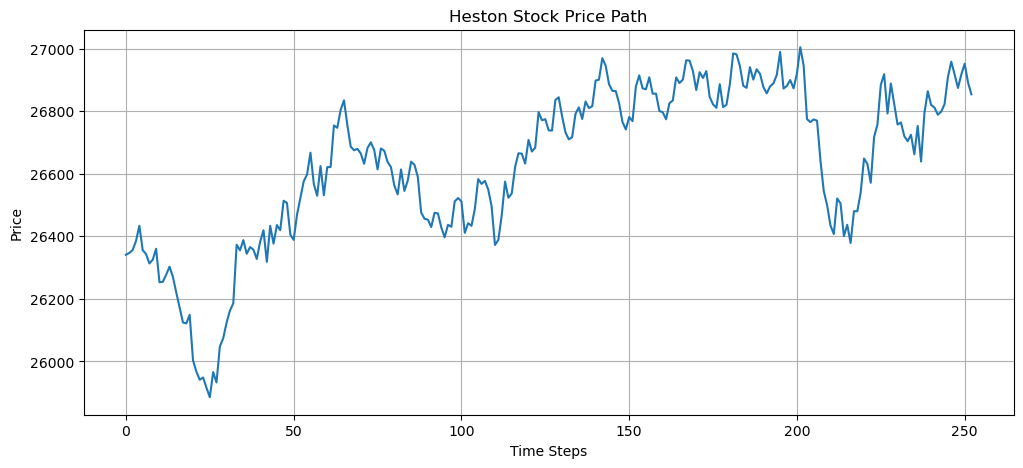

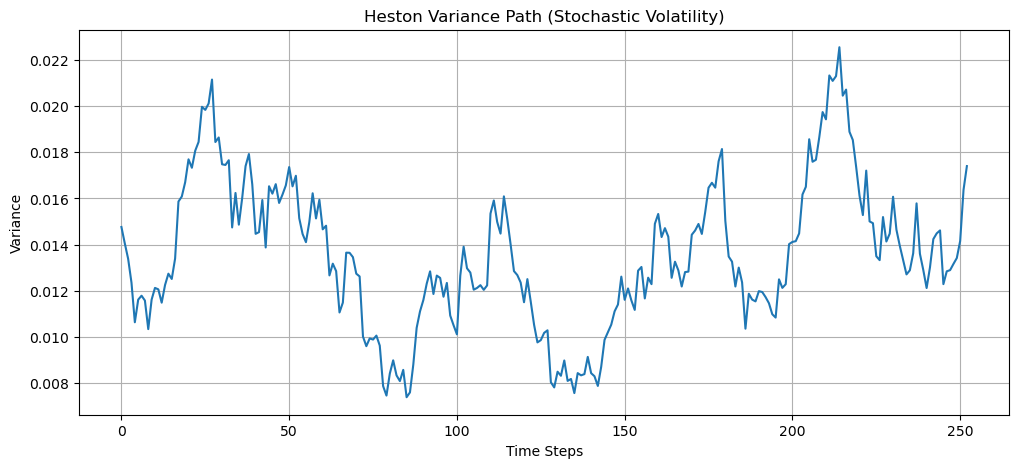

In [83]:
plt.figure(figsize=(12,5))
plt.plot(S_h)
plt.title("Heston Stock Price Path")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(v_h)
plt.title("Heston Variance Path (Stochastic Volatility)")
plt.xlabel("Time Steps")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

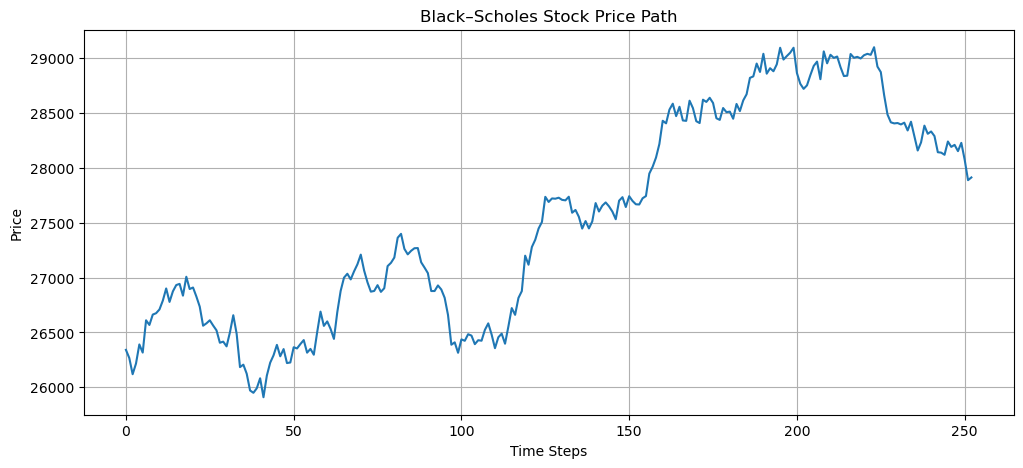

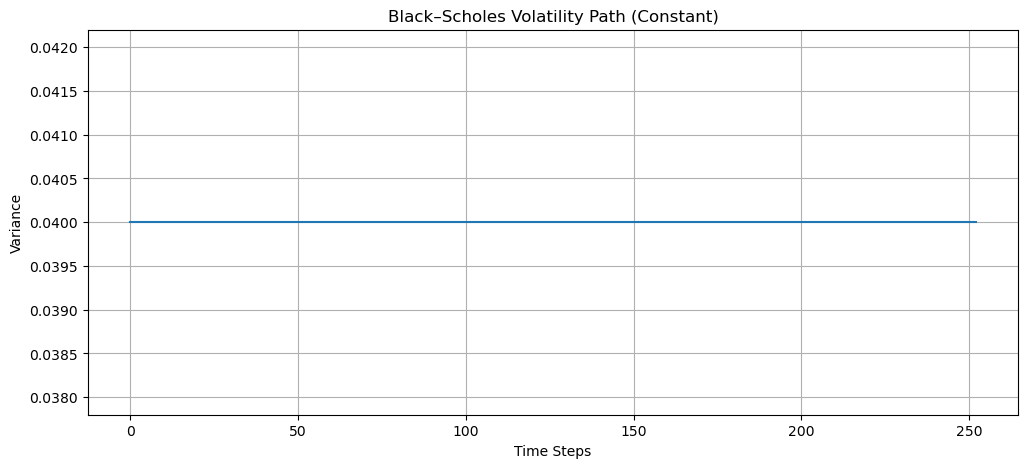

In [85]:
plt.figure(figsize=(12,5))
plt.plot(S_bs)
plt.title("Black–Scholes Stock Price Path")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(v_bs)
plt.title("Black–Scholes Volatility Path (Constant)")
plt.xlabel("Time Steps")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

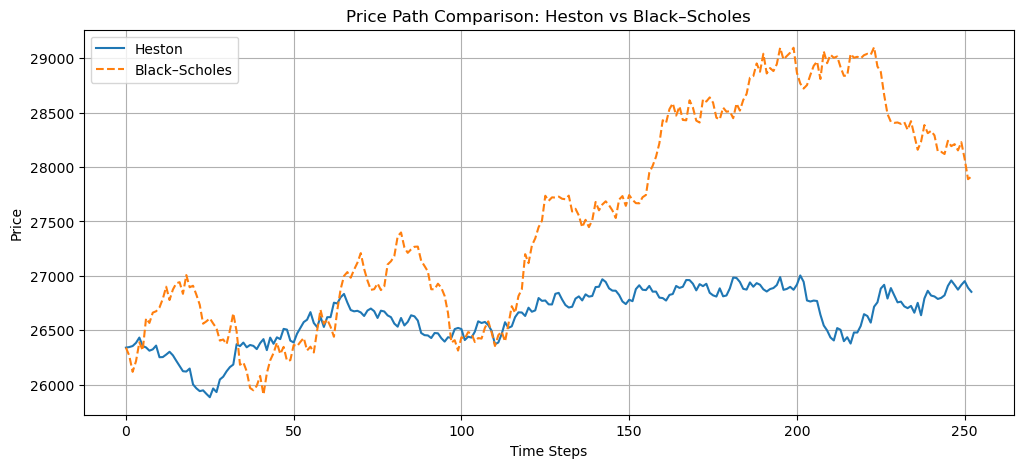

In [89]:
plt.figure(figsize=(12,5))
plt.plot(S_h, label="Heston")
plt.plot(S_bs, label="Black–Scholes", linestyle="--")
plt.title("Price Path Comparison: Heston vs Black–Scholes")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

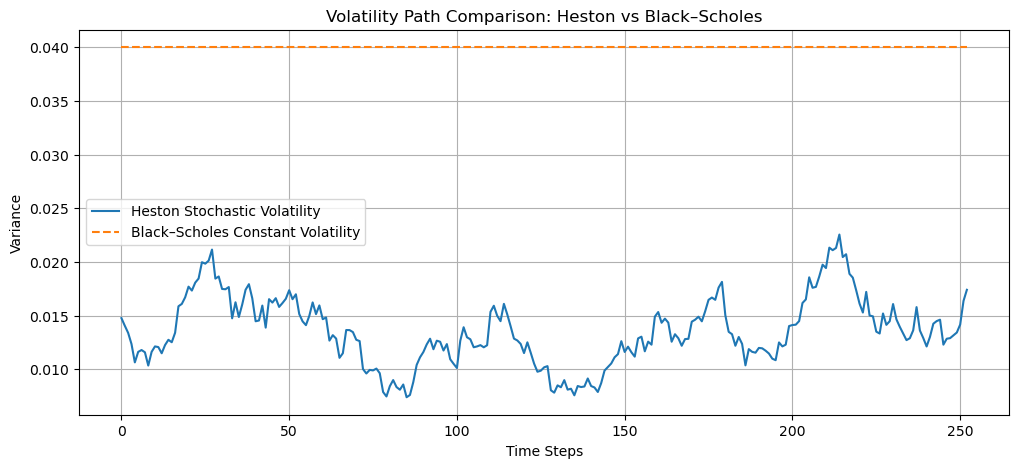

In [91]:
plt.figure(figsize=(12,5))
plt.plot(v_h, label="Heston Stochastic Volatility")
plt.plot(v_bs, label="Black–Scholes Constant Volatility", linestyle="--")
plt.title("Volatility Path Comparison: Heston vs Black–Scholes")
plt.xlabel("Time Steps")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.show()

Running Monte Carlo pricing for Heston and Black-Scholes...
Processing strike: 31,000
Heston vs Black-Scholes vs Market Values (30 Days Expiry)
 Strike  Moneyness  Heston_Call  BS_Call  Intrinsic_Call  Heston_Put  BS_Put  Intrinsic_Put  IV_Heston_Call_%  IV_Heston_Put_%  IV_BS_Call_%  IV_BS_Put_%
  22000      0.835      4377.22  4379.06         4340.92        1.32    0.00           0.00             19.19            22.86         23.86          NaN
  22500      0.854      3880.63  3879.88         3840.92        3.91    0.00           0.00             21.92            22.82         21.17          NaN
  23000      0.873      3387.98  3380.71         3340.92       10.43    0.01           0.00             22.43            22.81         18.53        12.38
  23500      0.892      2903.41  2881.62         2840.92       25.04    0.10           0.00             22.62            22.82         15.98        12.10
  24000      0.911      2433.48  2383.21         2340.92       54.29    0.87          

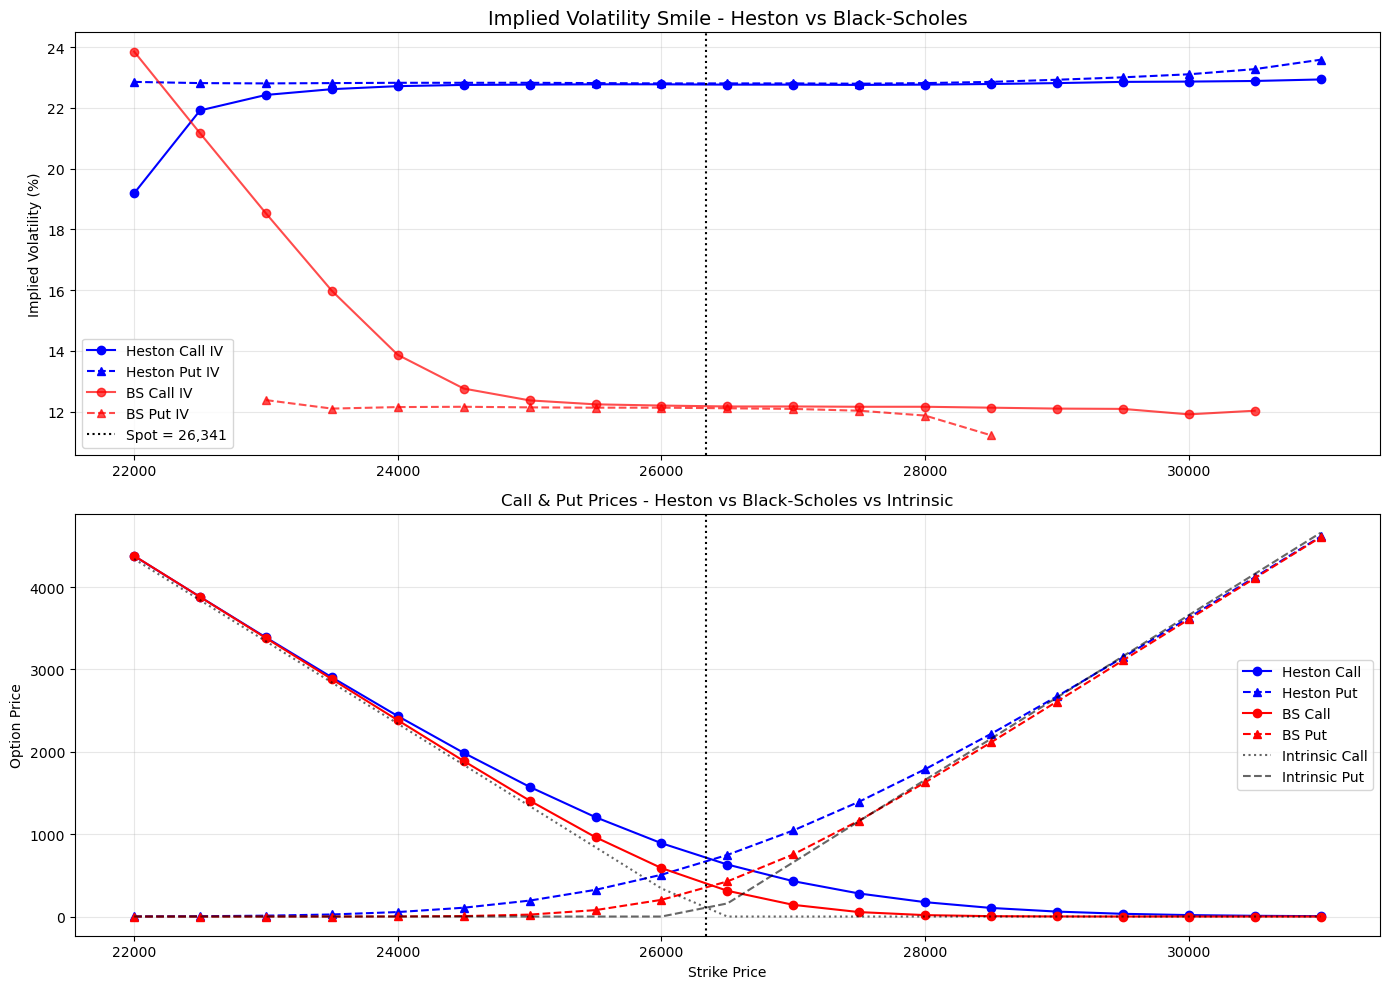


Done! You now have a complete comparison in DataFrame + Excel + plots.


In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

# =============================
# Black-Scholes Closed Form (for IV)
# =============================
def bs_price(S, K, T, r, sigma, type="call"):
    if T <= 0:
        payoff = max(S - K, 0) if type == "call" else max(K - S, 0)
        return payoff * np.exp(-r * T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# =============================
# Robust Implied Volatility
# =============================
def implied_vol(price, S, K, T, r, type="call"):
    if price <= 0: return np.nan
    def objective(sigma):
        return bs_price(S, K, T, r, sigma, type) - price
    try:
        return brentq(objective, 1e-6, 5.0, xtol=1e-8, maxiter=100)
    except:
        return np.nan

# =============================
# Heston Monte Carlo (Full Truncation - Stable)
# =============================
def heston_simulate(S0, v0, kappa, theta, sigma_v, rho, r, T, steps=50, paths=120000, seed=42):
    np.random.seed(seed)
    dt = T / steps
    S = np.full(paths, S0)
    v = np.full(paths, v0)

    for _ in range(steps):
        Z1 = np.random.normal(size=paths)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.normal(size=paths)
        v_plus = np.maximum(v, 0)
        v = v_plus + kappa * (theta - v_plus) * dt + sigma_v * np.sqrt(v_plus) * np.sqrt(dt) * Z2
        v = np.maximum(v, 0)
        S = S * np.exp((r - 0.5 * v_plus) * dt + np.sqrt(v_plus) * np.sqrt(dt) * Z1)
    return S

# =============================
# Black-Scholes Monte Carlo
# =============================
def bs_simulate(S0, sigma, r, T, paths=120000, seed=42):
    np.random.seed(seed)
    Z = np.random.normal(size=paths)
    return S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# =============================
# Parameters
# =============================
S0 = 26340.92
r  = 0.02
T  = 30 / 365.0
paths = 120000
steps = 50

# Heston Parameters (realistic equity skew)
v0      = 0.014728
kappa   = 2.0
theta   = 0.5
sigma_v = 0.
rho     = -0.75

# BS volatility (match ATM)
sigma_bs = np.sqrt(v0)  # ~20%

# Strikes
strikes = np.arange(22000, 31001, 500)

print("Running Monte Carlo pricing for Heston and Black-Scholes...")

# =============================
# Run Simulations
# =============================
results = []

for K in strikes:
    print(f"Processing strike: {K:,}", end="\r")
    
    # --- Heston ---
    S_heston = heston_simulate(S0, v0, kappa, theta, sigma_v, rho, r, T, steps, paths)
    heston_call = np.exp(-r*T) * np.mean(np.maximum(S_heston - K, 0))
    heston_put  = np.exp(-r*T) * np.mean(np.maximum(K - S_heston, 0))
    
    # --- Black-Scholes ---
    S_bs = bs_simulate(S0, sigma_bs, r, T, paths)
    bs_call = np.exp(-r*T) * np.mean(np.maximum(S_bs - K, 0))
    bs_put  = np.exp(-r*T) * np.mean(np.maximum(K - S_bs, 0))
    
    # --- Intrinsic / Market Reference ---
    intrinsic_call = max(S0 - K, 0)
    intrinsic_put  = max(K - S0, 0)
    
    # --- Implied Vols ---
    iv_heston_call = implied_vol(heston_call, S0, K, T, r, "call")
    iv_heston_put  = implied_vol(heston_put,  S0, K, T, r, "put")
    iv_bs_call     = implied_vol(bs_call,     S0, K, T, r, "call")
    iv_bs_put      = implied_vol(bs_put,      S0, K, T, r, "put")
    
    results.append({
        'Strike': K,
        'Moneyness': round(K / S0, 3),
        
        # Prices
        'Heston_Call': round(heston_call, 2),
        'Heston_Put' : round(heston_put,  2),
        'BS_Call'    : round(bs_call,     2),
        'BS_Put'     : round(bs_put,      2),
        'Intrinsic_Call': intrinsic_call,
        'Intrinsic_Put' : intrinsic_put,
        
        # Implied Vols (%)
        'IV_Heston_Call_%': round(iv_heston_call * 100, 2) if not np.isnan(iv_heston_call) else np.nan,
        'IV_Heston_Put_%' : round(iv_heston_put  * 100, 2) if not np.isnan(iv_heston_put)  else np.nan,
        'IV_BS_Call_%'    : round(iv_bs_call     * 100, 2) if not np.isnan(iv_bs_call)     else np.nan,
        'IV_BS_Put_%'     : round(iv_bs_put      * 100, 2) if not np.isnan(iv_bs_put)      else np.nan,
    })

# =============================
# Create DataFrame
# =============================
df = pd.DataFrame(results)
df = df[['Strike', 'Moneyness',
         'Heston_Call', 'BS_Call', 'Intrinsic_Call',
         'Heston_Put',  'BS_Put',  'Intrinsic_Put',
         'IV_Heston_Call_%', 'IV_Heston_Put_%',
         'IV_BS_Call_%',     'IV_BS_Put_%']]

print("\n" + "="*110)
print("Heston vs Black-Scholes vs Market Values (30 Days Expiry)")
print("="*110)
print(df.to_string(index=False))
print("="*110)

# =============================
# Save to Excel (optional)
# =============================
df.to_excel("Heston_vs_BS_Comparison.xlsx", index=False)
print("\nSaved to 'Heston_vs_BS_Comparison.xlsx'")

# =============================
# Plot Results
# =============================
plt.figure(figsize=(14, 10))

# Plot 1: Implied Volatility Smile
plt.subplot(2, 1, 1)
plt.plot(df['Strike'], df['IV_Heston_Call_%'], 'bo-', label='Heston Call IV', markersize=6)
plt.plot(df['Strike'], df['IV_Heston_Put_%'],  'b^--', label='Heston Put IV', markersize=6)
plt.plot(df['Strike'], df['IV_BS_Call_%'],     'ro-', alpha=0.7, label='BS Call IV')
plt.plot(df['Strike'], df['IV_BS_Put_%'],      'r^--', alpha=0.7, label='BS Put IV')
plt.axvline(S0, color='black', linestyle=':', label=f'Spot = {S0:,.0f}')
plt.title('Implied Volatility Smile - Heston vs Black-Scholes', fontsize=14)
plt.ylabel('Implied Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Option Prices
plt.subplot(2, 1, 2)
plt.plot(df['Strike'], df['Heston_Call'], 'bo-', label='Heston Call')
plt.plot(df['Strike'], df['Heston_Put'],  'b^--', label='Heston Put')
plt.plot(df['Strike'], df['BS_Call'],     'ro-', label='BS Call')
plt.plot(df['Strike'], df['BS_Put'],      'r^--', label='BS Put')
plt.plot(df['Strike'], df['Intrinsic_Call'], 'k:', alpha=0.6, label='Intrinsic Call')
plt.plot(df['Strike'], df['Intrinsic_Put'],  'k--', alpha=0.6, label='Intrinsic Put')
plt.axvline(S0, color='black', linestyle=':')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Call & Put Prices - Heston vs Black-Scholes vs Intrinsic')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDone! You now have a complete comparison in DataFrame + Excel + plots.")